# **USD/JPY Prediction Using Tree-Based Models: An Explainable AI Approach**

## **Data Preparation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/drive")
file_path = "/content/drive/MyDrive/COIL Group 3/Data/sample_coil - Group 3.xlsx" #change file location
df = pd.read_excel(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pandas.core.arrays.categorical import factorize_from_iterable
#data preparation
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

#calculate return target available
df['USD/JPY_Returns'] = df['USD/JPY'].pct_change() * 100

#calculate features returns and lag features (x)
#use t-1 data to predict t return
df['S&P 500_Returns'] = df['S&P 500'].pct_change() * 100
df['Lag_SP500'] = df['S&P 500_Returns'].shift(1)
df['Nikkei 225_Returns'] = df['Nikkei 225'].pct_change() * 100
df['Lag_Nikkei'] = df['Nikkei 225_Returns'].shift(1)

#use lag level for US EPU
df['Lag_US_EPU'] = df['US EPU'].shift(1)

#final features & target
features = ['Lag_SP500', 'Lag_Nikkei', 'Lag_US_EPU']
target = 'USD/JPY_Returns'

df_final = df.dropna(subset=[target] + features)

X = df_final[features]
y = df_final[target]

## **Time Series**

In [ ]:
split_index = int(0.8 * len(df_final))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

## **Train Random Forest Model**


In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=200, #increase it for better performance
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=200, n_jobs=-1, random_state=42)

## **Traditional Features Important Plot**

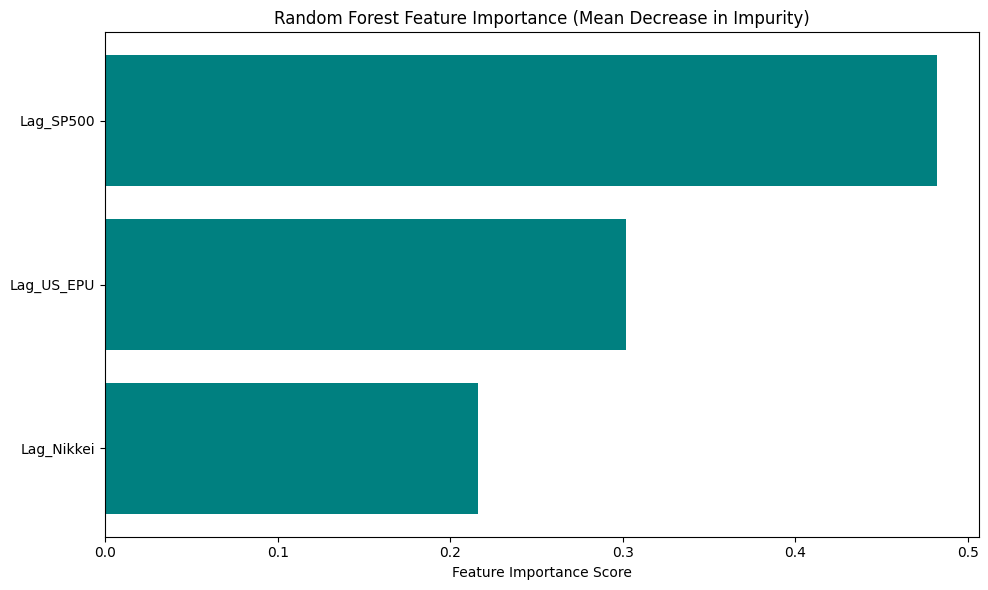

In [ ]:
fi = rf_model.feature_importances_
sorted_idx = fi.argsort()

fig, ax = plt.subplots(figsize = (10, 6))
ax.barh(np.array(features)[sorted_idx], fi[sorted_idx], color = 'teal')
ax.set_title('Random Forest Feature Importance (Mean Decrease in Impurity)')
ax.set_xlabel('Feature Importance Score')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()

## **Explainable AI (XAI) with SHAP**

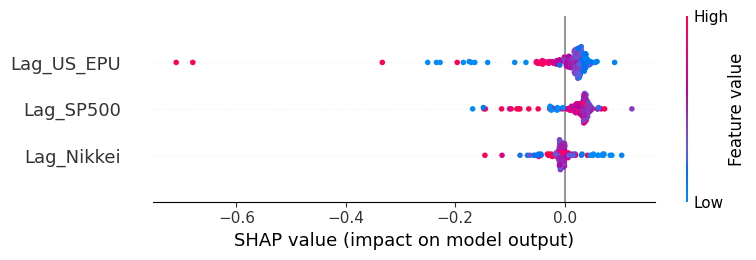

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(rf_model)

X_test_sample = X_test.sample(n = min(300, len(X_test)), random_state = 42)
shap_values = explainer.shap_values(X_test_sample)

#SHAP Summary Plot
plt.figure(figsize = (10, 6))
shap.summary_plot(shap_values, X_test_sample, plot_type = 'dot', show = False)
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
plt.show()

## **Actual vs Predicted Plot**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


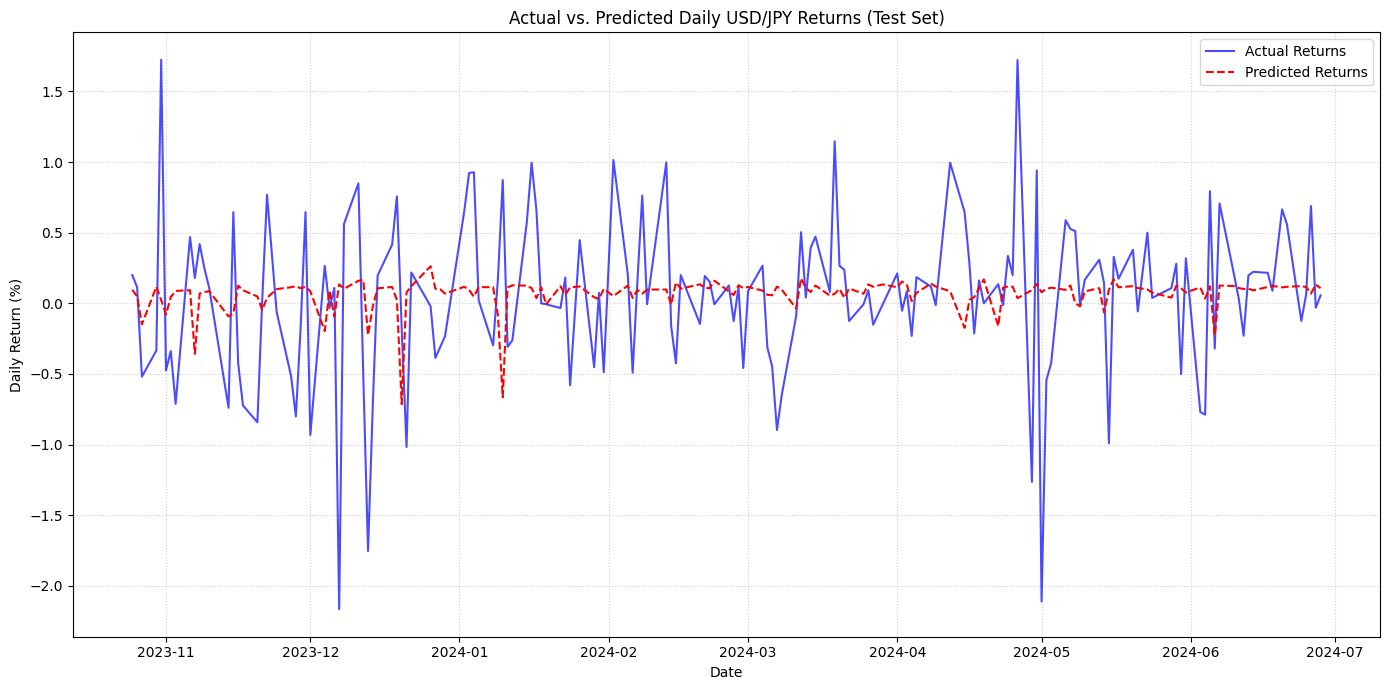

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount("/content/drive")
file_path = "/content/drive/MyDrive/COIL Group 3/Data/sample_coil - Group 3.xlsx"
df = pd.read_excel(file_path)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['USD/JPY_Returns'] = df['USD/JPY'].pct_change() * 100
df['S&P 500_Returns'] = df['S&P 500'].pct_change() * 100
df['Lag_SP500'] = df['S&P 500_Returns'].shift(1)
df['Nikkei 225_Returns'] = df['Nikkei 225'].pct_change() * 100
df['Lag_Nikkei'] = df['Nikkei 225_Returns'].shift(1)
df['Lag_US_EPU'] = df['US EPU'].shift(1)

features = ['Lag_SP500', 'Lag_Nikkei', 'Lag_US_EPU']
target = 'USD/JPY_Returns'
df_final = df.dropna(subset=[target] + features)

X = df_final[features]
y = df_final[target]

split_index = int(0.8 * len(df)) # The split_index was originally using len(df) instead of len(df_final). Changed to df_final.
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results_df.index = X_test.index

plt.figure(figsize = (14, 7))
plt.plot(results_df.index, results_df['Actual'], label = 'Actual Returns', color = 'blue', alpha = 0.7)
plt.plot(results_df.index, results_df['Predicted'], label = 'Predicted Returns', color = 'red', linestyle = '--')

plt.title('Actual vs. Predicted Daily USD/JPY Returns (Test Set)')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True, linestyle = ':', alpha = 0.6)
plt.tight_layout()
plt.savefig('actual_vs_predicted_returns.png')
plt.show()

## **LASSO Filtering**

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (664, 3)
X_test_scaled shape: (164, 3)


In [ ]:
from sklearn.linear_model import LassoCV
import numpy as np

# 2. Instantiate LassoCV
# cv=5 for 5-fold cross-validation
# random_state for reproducibility
lasso_model = LassoCV(cv=5, random_state=42, n_jobs=-1)

# 3. Fit the LassoCV model on X_train_scaled and y_train
lasso_model.fit(X_train_scaled, y_train)

# 4. Identify the non-zero coefficients to determine selected features
# Get the coefficients from the fitted model
coefficients = lasso_model.coef_

# Get the names of the original features
original_feature_names = features

# Identify selected feature names (where coefficients are not zero)
selected_features_mask = (coefficients != 0)
selected_feature_names = np.array(original_feature_names)[selected_features_mask].tolist()

print("Optimal alpha found by LassoCV:", lasso_model.alpha_)
print("Coefficients:", coefficients)
print("Selected features:", selected_feature_names)


Optimal alpha found by LassoCV: 0.04200381424115012
Coefficients: [-0.00000000e+00 -0.00000000e+00 -1.60514172e-17]
Selected features: ['Lag_US_EPU']


In [ ]:
import pandas as pd

# Create X_train_lasso and X_test_lasso with only selected features
# Use the selected_features_mask to select columns from the scaled numpy arrays
X_train_lasso = pd.DataFrame(X_train_scaled[:, selected_features_mask], columns=selected_feature_names, index=X_train.index)
X_test_lasso = pd.DataFrame(X_test_scaled[:, selected_features_mask], columns=selected_feature_names, index=X_test.index)

print("X_train_lasso shape:", X_train_lasso.shape)
print("X_test_lasso shape:", X_test_lasso.shape)
print("X_train_lasso head:\n", X_train_lasso.head())
print("X_test_lasso head:\n", X_test_lasso.head())

X_train_lasso shape: (664, 1)
X_test_lasso shape: (164, 1)
X_train_lasso head:
             Lag_US_EPU
date                  
2021-01-06    1.360469
2021-01-07    0.153423
2021-01-08   -0.118864
2021-01-12   -0.460802
2021-01-13    1.720828
X_test_lasso head:
             Lag_US_EPU
date                  
2023-10-25   -0.898180
2023-10-26   -0.120268
2023-10-27   -1.634338
2023-10-30   -0.717475
2023-10-31    0.579398


## **Re-train the Random Forest Model**


In [ ]:
# Initialize a new Random Forest Regressor with the same hyperparameters
rf_model_lasso = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model using the LASSO-filtered training data
rf_model_lasso.fit(X_train_lasso, y_train)

print("Random Forest model retrained with LASSO-filtered features successfully!")

Random Forest model retrained with LASSO-filtered features successfully!


## **Comparison between Random Forest and LASSO Model**


--- Original Random Forest Model Performance ---
Mean Absolute Error (MAE): 0.4214
Mean Squared Error (MSE): 0.3419
R-squared (R2): -0.0421

--- LASSO-Filtered Random Forest Model Performance ---
Mean Absolute Error (MAE): 0.4185
Mean Squared Error (MSE): 0.3346
R-squared (R2): -0.0197


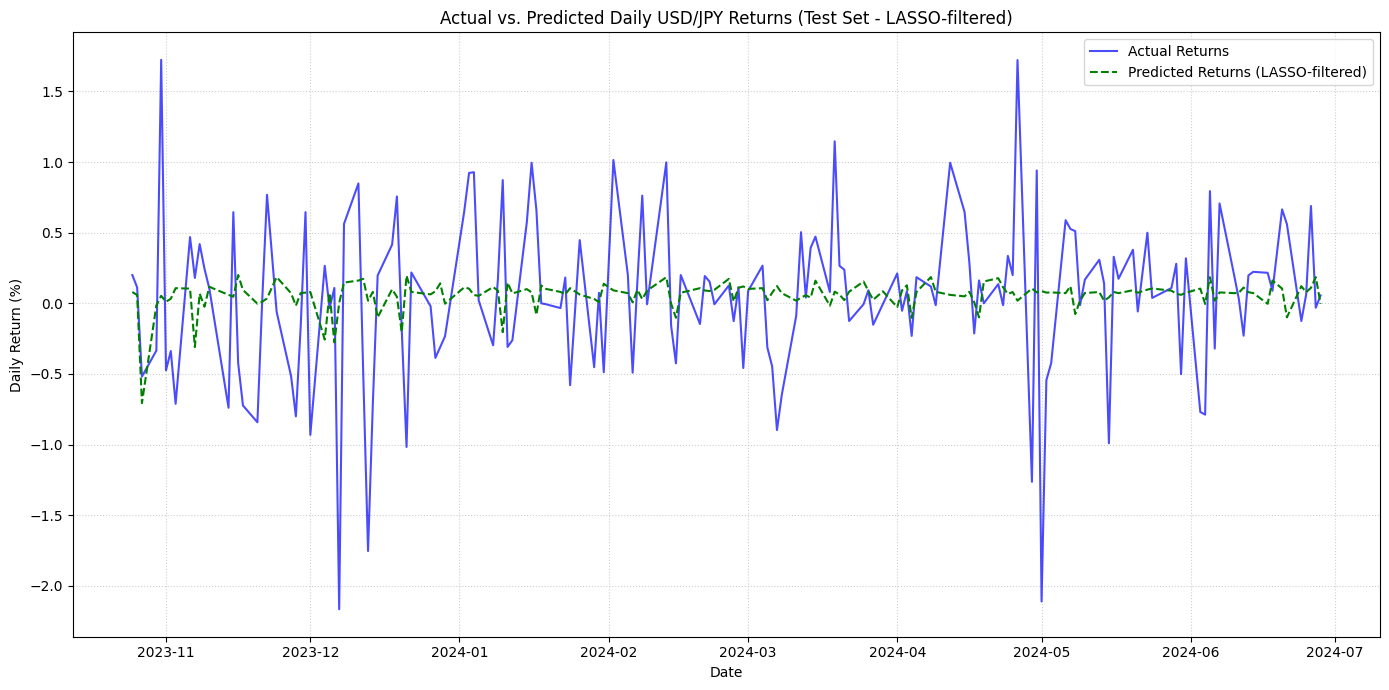

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Original Model Evaluation ---
# Predictions from the original model
y_pred_original = rf_model.predict(X_test)

# Calculate metrics for the original model
mae_original = mean_absolute_error(y_test, y_pred_original)
mse_original = mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

print("\n--- Original Random Forest Model Performance ---")
print(f"Mean Absolute Error (MAE): {mae_original:.4f}")
print(f"Mean Squared Error (MSE): {mse_original:.4f}")
print(f"R-squared (R2): {r2_original:.4f}")

# --- LASSO-filtered Model Evaluation ---
# Predictions from the LASSO-filtered model
y_pred_lasso = rf_model_lasso.predict(X_test_lasso)

# Calculate metrics for the LASSO-filtered model
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n--- LASSO-Filtered Random Forest Model Performance ---")
print(f"Mean Absolute Error (MAE): {mae_lasso:.4f}")
print(f"Mean Squared Error (MSE): {mse_lasso:.4f}")
print(f"R-squared (R2): {r2_lasso:.4f}")

# --- Visual Comparison: Actual vs. Predicted for LASSO-filtered Model ---
import matplotlib.pyplot as plt
import pandas as pd

results_df_lasso = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_lasso
})
results_df_lasso.index = X_test_lasso.index # Ensure index aligns

plt.figure(figsize = (14, 7))
plt.plot(results_df_lasso.index, results_df_lasso['Actual'], label = 'Actual Returns', color = 'blue', alpha = 0.7)
plt.plot(results_df_lasso.index, results_df_lasso['Predicted'], label = 'Predicted Returns (LASSO-filtered)', color = 'green', linestyle = '--')

plt.title('Actual vs. Predicted Daily USD/JPY Returns (Test Set - LASSO-filtered)')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True, linestyle = ':', alpha = 0.6)
plt.tight_layout()
plt.savefig('actual_vs_predicted_returns_lasso.png')
plt.show()

## **Explainable AI (XAI) Analyst**

In [ ]:
explainer_lasso = shap.TreeExplainer(rf_model_lasso)

X_test_lasso_sample = X_test_lasso.sample(n = min(300, len(X_test_lasso)), random_state = 42)
shap_values_lasso = explainer_lasso.shap_values(X_test_lasso_sample)

print("SHAP values for LASSO-filtered model calculated successfully!")

SHAP values for LASSO-filtered model calculated successfully!


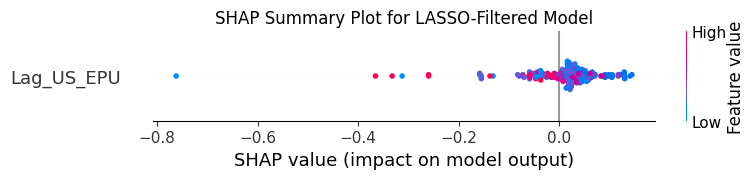

SHAP summary plot for LASSO-filtered model generated and saved as 'shap_summary_plot_lasso.png' successfully!


In [ ]:
import matplotlib.pyplot as plt

# SHAP Summary Plot for LASSO-filtered model
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_lasso, X_test_lasso_sample, plot_type='dot', show=False)
plt.title('SHAP Summary Plot for LASSO-Filtered Model')
plt.tight_layout()
plt.savefig('shap_summary_plot_lasso.png')
plt.show()

print("SHAP summary plot for LASSO-filtered model generated and saved as 'shap_summary_plot_lasso.png' successfully!")

In [ ]:
get_ipython().system('pip install lime')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fb55b02307813185dfe1ef853e2abdf1635e24c6853b3e926e12ddb499ce1802
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
print("LimeTabularExplainer imported successfully.")

LimeTabularExplainer imported successfully.


In [ ]:
X_train_array = X_train.values
feature_names = features

print("X_train converted to NumPy array with shape:", X_train_array.shape)
print("Feature names:", feature_names)

X_train converted to NumPy array with shape: (664, 3)
Feature names: ['Lag_SP500', 'Lag_Nikkei', 'Lag_US_EPU']


In [ ]:
explainer_lime = LimeTabularExplainer(
    training_data=X_train_array,
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=True
)

print("LimeTabularExplainer initialized successfully.")

LimeTabularExplainer initialized successfully.


In [ ]:
def predict_fn(data):
    return rf_model.predict(data)

print("Prediction function 'predict_fn' defined successfully.")

Prediction function 'predict_fn' defined successfully.


In [ ]:
data_for_explanation = X_test.iloc[0].values
explanation = explainer_lime.explain_instance(
    data_row=data_for_explanation,
    predict_fn=predict_fn,
    num_features=len(feature_names)
)

print("LIME explanation generated for the first instance in X_test.")
print("Explanation as a list of (feature, weight) tuples:", explanation.as_list())

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


LIME explanation generated for the first instance in X_test.
Explanation as a list of (feature, weight) tuples: [('Lag_SP500 > 0.71', -0.052137097115554844), ('Lag_US_EPU <= 91.44', 0.03656708280166654), ('-0.71 < Lag_Nikkei <= 0.10', -0.014567982788197471)]


In [ ]:
def predict_fn(data):
    # Convert the NumPy array back to a DataFrame with feature names
    data_df = pd.DataFrame(data, columns=feature_names)
    return rf_model.predict(data_df)

print("Prediction function 'predict_fn' redefined to handle feature names successfully.")

Prediction function 'predict_fn' redefined to handle feature names successfully.


In [ ]:
data_for_explanation = X_test.iloc[0].values
explanation = explainer_lime.explain_instance(
    data_row=data_for_explanation,
    predict_fn=predict_fn,
    num_features=len(feature_names)
)

print("LIME explanation generated for the first instance in X_test (with updated predict_fn).")
print("Explanation as a list of (feature, weight) tuples:", explanation.as_list())

LIME explanation generated for the first instance in X_test (with updated predict_fn).
Explanation as a list of (feature, weight) tuples: [('Lag_SP500 > 0.71', -0.05447070867681357), ('Lag_US_EPU <= 91.44', 0.037608169970791964), ('-0.71 < Lag_Nikkei <= 0.10', -0.009780495971136173)]
